In [ ]:
import os
import pandas as pd
import numpy as np
import datetime

import itertools

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from numpy import *
import tensorflow as tf
import random as rn
import sys 
from numpy.random import seed
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from pandas import Series
from pandas import concat
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from math import sqrt
from numpy import concatenate
from tensorflow.python.keras import backend as k

pd.set_option('display.float_format', lambda x: '{:.15f}'.format(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [ ]:
'''
https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816
'''

'\nhttps://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816\n'

In [ ]:
df_shipment = pd.read_csv('result_shipment_only.csv')
#df2 = pd.read_csv('result_shipment_only_2.csv')
#df3 = pd.read_csv('result_shipment_only_3.csv')
#df = pd.concat([df1, df2, df3])
#df_shipment = df_shipment.assign(generic_cust_item_id=(df_shipment['UCH_LEVEL_G'].astype(str) + '_' + df_shipment['BASECODE'].astype(str)).astype('category').cat.codes)
df_shipment.columns = [c.lower() for c in df_shipment.columns]
#Converting fscl_wk_end_dt column to datetime format
df_shipment['fscl_wk_end_dt'] = pd.to_datetime(df_shipment['fscl_wk_end_dt'])
#df_shipment.set_index('fscl_wk_end_dt', inplace=True)
#df_shipment

df_cust_po = pd.read_csv('result_cust_po.csv')
#df2 = pd.read_csv('result_shipment_only_2.csv')
#df3 = pd.read_csv('result_shipment_only_3.csv')
#df = pd.concat([df1, df2, df3])
#df_cust_po = df_cust_po.assign(generic_cust_item_id=(df_cust_po['UCH_LEVEL_G'].astype(str) + '_' + df_cust_po['BASECODE'].astype(str)).astype('category').cat.codes)
df_cust_po.columns = [c.lower() for c in df_cust_po.columns]
#Converting fscl_wk_end_dt column to datetime format
df_cust_po['fscl_wk_end_dt'] = pd.to_datetime(df_cust_po['fscl_wk_end_dt'])
#df_cust_po.set_index('fscl_wk_end_dt', inplace=True)
#df_cust_po

df_po_vs_shipment = pd.merge(df_shipment[['uch_level_g','basecode','fscl_wk_end_dt','sales_document','material','dlv_units']], df_cust_po[['uch_level_g','basecode','fscl_wk_end_dt','sales_document','material','total_units_ordered']], on=['uch_level_g','basecode','fscl_wk_end_dt','sales_document','material'], how="inner")
df_po_vs_shipment = df_po_vs_shipment.assign(generic_cust_item_id=(df_po_vs_shipment['uch_level_g'].astype(str) + '_' + df_po_vs_shipment['basecode'].astype(str)).astype('category').cat.codes)

df_po_vs_shipment.set_index(['fscl_wk_end_dt'], inplace=True)
df_po_vs_shipment.total_units_ordered = df_po_vs_shipment.total_units_ordered.astype(int)
df_po_vs_shipment = df_po_vs_shipment[['uch_level_g','basecode','generic_cust_item_id', 'dlv_units']]
df_po_vs_shipment.to_csv('df_po_vs_shipment.csv')
#df_po_vs_shipment

df_po_vs_shipment_agg=df_po_vs_shipment.reset_index().groupby(['uch_level_g','basecode','generic_cust_item_id', 'fscl_wk_end_dt'])[["dlv_units"]].agg(["sum"]).reset_index()
df_po_vs_shipment_agg.columns = ['uch_level_g','basecode','generic_cust_item_id', 'fscl_wk_end_dt','dlv_units']

df_po_vs_shipment_agg_stat=df_po_vs_shipment_agg.groupby(['uch_level_g','basecode','generic_cust_item_id'])[["dlv_units"]].agg(["count","sum","mean","std"])
df_po_vs_shipment_agg_stat.columns = ['dlv_units_count','dlv_units_sum','dlv_units_avg','dlv_units_std']
df_po_vs_shipment_agg_stat['dlv_units_cv_times_cnt'] = (df_po_vs_shipment_agg_stat.dlv_units_std / df_po_vs_shipment_agg_stat.dlv_units_avg) * df_po_vs_shipment_agg_stat.dlv_units_count
df_po_vs_shipment_agg_stat.reset_index(inplace=True)

#df_po_vs_shipment_agg_stat = df_po_vs_shipment_agg_stat.assign(generic_cust_item_id=(df_po_vs_shipment_agg_stat['uch_level_g'].astype(str) + '_' + df_po_vs_shipment_agg_stat['basecode'].astype(str)).astype('category').cat.codes)
df_po_vs_shipment_agg_stat = df_po_vs_shipment_agg_stat.assign(generic_cust_id=(df_po_vs_shipment_agg_stat['uch_level_g'].astype(str)).astype('category').cat.codes)
df_po_vs_shipment_agg_stat = df_po_vs_shipment_agg_stat.assign(generic_item_id=(df_po_vs_shipment_agg_stat['basecode'].astype(str)).astype('category').cat.codes)
df_po_vs_shipment_agg_stat = df_po_vs_shipment_agg_stat.dropna()
#df_po_vs_shipment_agg_stat.head()

df_po_vs_shipment_agg_stat_orig = df_po_vs_shipment_agg_stat.copy()
df_po_vs_shipment_agg_stat = df_po_vs_shipment_agg_stat[df_po_vs_shipment_agg_stat.dlv_units_count > 70]
df_po_vs_shipment_agg_orig_1 = df_po_vs_shipment_agg.copy()
df_po_vs_shipment_agg = pd.merge(df_po_vs_shipment_agg, df_po_vs_shipment_agg_stat, how = 'inner', on = ['uch_level_g','basecode','generic_cust_item_id'])[['uch_level_g','basecode','generic_cust_item_id','dlv_units', 'fscl_wk_end_dt']]
df_po_vs_shipment_agg.set_index('fscl_wk_end_dt', inplace=True)
df_po_vs_shipment_agg = df_po_vs_shipment_agg[['uch_level_g','basecode','generic_cust_item_id','dlv_units']]
df_po_vs_shipment_agg['uch_level_g_basecode'] = 'cust_' + df_po_vs_shipment_agg['uch_level_g'] + '_basecode_' + df_po_vs_shipment_agg['basecode'].astype(str)
col_dict = {}
for index, row in df_po_vs_shipment_agg[['uch_level_g','basecode','generic_cust_item_id']].iterrows():
    col_dict['generic_cust_item_id_' + str(row[2])] = 'cust_' + row[0] + '_basecode_' + str(row[1])
col_dict  
df_po_vs_shipment_agg.head()

,uch_level_g,basecode,generic_cust_item_id,dlv_units,uch_level_g_basecode
fscl_wk_end_dt,,,,,
2017-12-02,CA4000326,681000112500,33,100,cust_CA4000326_basecode_681000112500
2017-12-09,CA4000326,681000112500,33,75,cust_CA4000326_basecode_681000112500
2017-12-16,CA4000326,681000112500,33,140,cust_CA4000326_basecode_681000112500
2017-12-23,CA4000326,681000112500,33,140,cust_CA4000326_basecode_681000112500
2017-12-30,CA4000326,681000112500,33,100,cust_CA4000326_basecode_681000112500


In [ ]:
np.random.seed(42)
rn.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.random.set_seed(1234)

sess =  tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [ ]:
def inverse_difference(last_ob, value):
    return value + last_ob

In [ ]:
def MAPE(x,y):
    result=0
    for i in range(len(x)):
		    result += abs((x[i]-y[i])/x[i])
    result /= len(x)
    result *= 100
    return result

In [ ]:
def RMSE(x,y):
    result=0
    for i in range(len(x)):
        result += ((x[i]-y[i])/x[i])**2
    result /= len(x)
    return result

In [ ]:
def dRMSE(y_true, y_pred):
    dy_true=np.diff(y_true, axis=0)
    dy_pred=np.diff(y_pred, axis=0)
    result=0
    for i in range(len(dy_true)):
        result += ((dy_true[i]-dy_pred[i])/dy_true[i])**2
    result /= len(dy_true)
    result = sqrt(result)
    return result

In [ ]:
df_bottom_level = df_po_vs_shipment_agg.pivot(columns="generic_cust_item_id", values="dlv_units")
df_bottom_level = df_bottom_level.fillna(0)
df_bottom_level.columns = ['generic_cust_item_id_' + str(c) for c in df_bottom_level.columns]
modified_col_list = []
for c in df_bottom_level.columns:
    modified_col_list.append(col_dict[c])
df_bottom_level.columns = modified_col_list
df_bottom_level = df_bottom_level.asfreq('W-Sat')
df_bottom_level.head()

df_bottom_level.head()

,cust_CA4000326_basecode_681000112500,cust_CA4000326_basecode_681008959700,cust_CA4000342_basecode_681000112500,cust_CA4000342_basecode_681000145500,cust_CA4000342_basecode_681000145900,cust_CA4000342_basecode_681000146500,cust_CA4000342_basecode_681008959700,cust_CA4000350_basecode_681008959700,cust_CA4000350_basecode_681008960600,cust_CA4000350_basecode_681008962800,cust_CA4000350_basecode_681008963300,cust_CA4000366_basecode_681000112500,cust_CA4000366_basecode_681000145500,cust_CA4000366_basecode_681008959700,cust_CA4000388_basecode_681000112500,cust_CA4000388_basecode_681000145500,cust_CA4000388_basecode_681000145900,cust_CA4000388_basecode_681000146500,cust_CA4000388_basecode_681008959700,cust_CA4000388_basecode_681008965100,cust_CA4000401_basecode_681008959000,cust_CA4000401_basecode_681008959400,cust_CA4000401_basecode_681008959700,cust_CA4000401_basecode_681008962700,cust_CA4000401_basecode_681008963100,cust_CA4000408_basecode_681000145500,cust_CA4000408_basecode_681000145900,cust_CA4000408_basecode_681000146500,cust_CA4000408_basecode_681000147700,cust_CA4000410_basecode_681000145500,cust_CA4000410_basecode_681000145900,cust_CA4000410_basecode_681000146500,cust_CA4000410_basecode_681000147700,cust_CA4000410_basecode_681008938400,cust_CA4000410_basecode_681008959700,cust_CA4000435_basecode_681000112500,cust_CA4000435_basecode_681000145900,cust_CA4000435_basecode_681000146500,cust_CA4000435_basecode_681000147700,cust_CA4000435_basecode_681008958300,cust_CA4000435_basecode_681008959000,cust_CA4000435_basecode_681008959400,cust_CA4000435_basecode_681008959700,cust_CA4000435_basecode_681008963100,cust_CA4000663_basecode_681000112500,cust_CA4000806_basecode_681000112500,cust_CA4000806_basecode_681008958000,cust_CA4000806_basecode_681008959000,cust_CA4000806_basecode_681008959400,cust_CA4000806_basecode_681008959700,cust_CA4000806_basecode_681008965100,cust_CA4001315_basecode_681008965000
fscl_wk_end_dt,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-11-18,0.000000000000000,75.000000000000000,180.000000000000000,330.000000000000000,330.000000000000000,315.000000000000000,150.000000000000000,0.000000000000000,0.000000000000000,30.000000000000000,75.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,160.000000000000000,30.000000000000000,0.000000000000000,30.000000000000000,0.000000000000000,84.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,145.000000000000000,144.000000000000000,72.000000000000000,10.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,160.000000000000000,75.000000000000000,150.000000000000000,75.000000000000000,30.000000000000000,0.000000000000000,75.000000000000000,150.000000000000000,30.000000000000000,0.000000000000000,60.000000000000000,75.000000000000000,75.000000000000000,75.000000000000000,150.000000000000000,105.000000000000000,0.000000000000000
2017-11-25,0.000000000000000,75.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,1050.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,40.000000000000000,150.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,60.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,30.000000000000000,45.000000000000000,675.000000000000000,600.000000000000000,165.000000000000000,200.000000000000000,165.000000000000000,30.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,160.000000000000000,75.000000000000000,0.000000000000000,75.000000000000000,15.000000000000000,75.000000000000000,75.000000000000000,150.000000000000000,75.000000000000000,8.000000000000000,100.000000000000000,33.000000000000000,78.000000000000000,80.000000000000000,240.000000000000000,55.000000000000000,0.000000000000000
2017-12-02,100.000000000000000,7

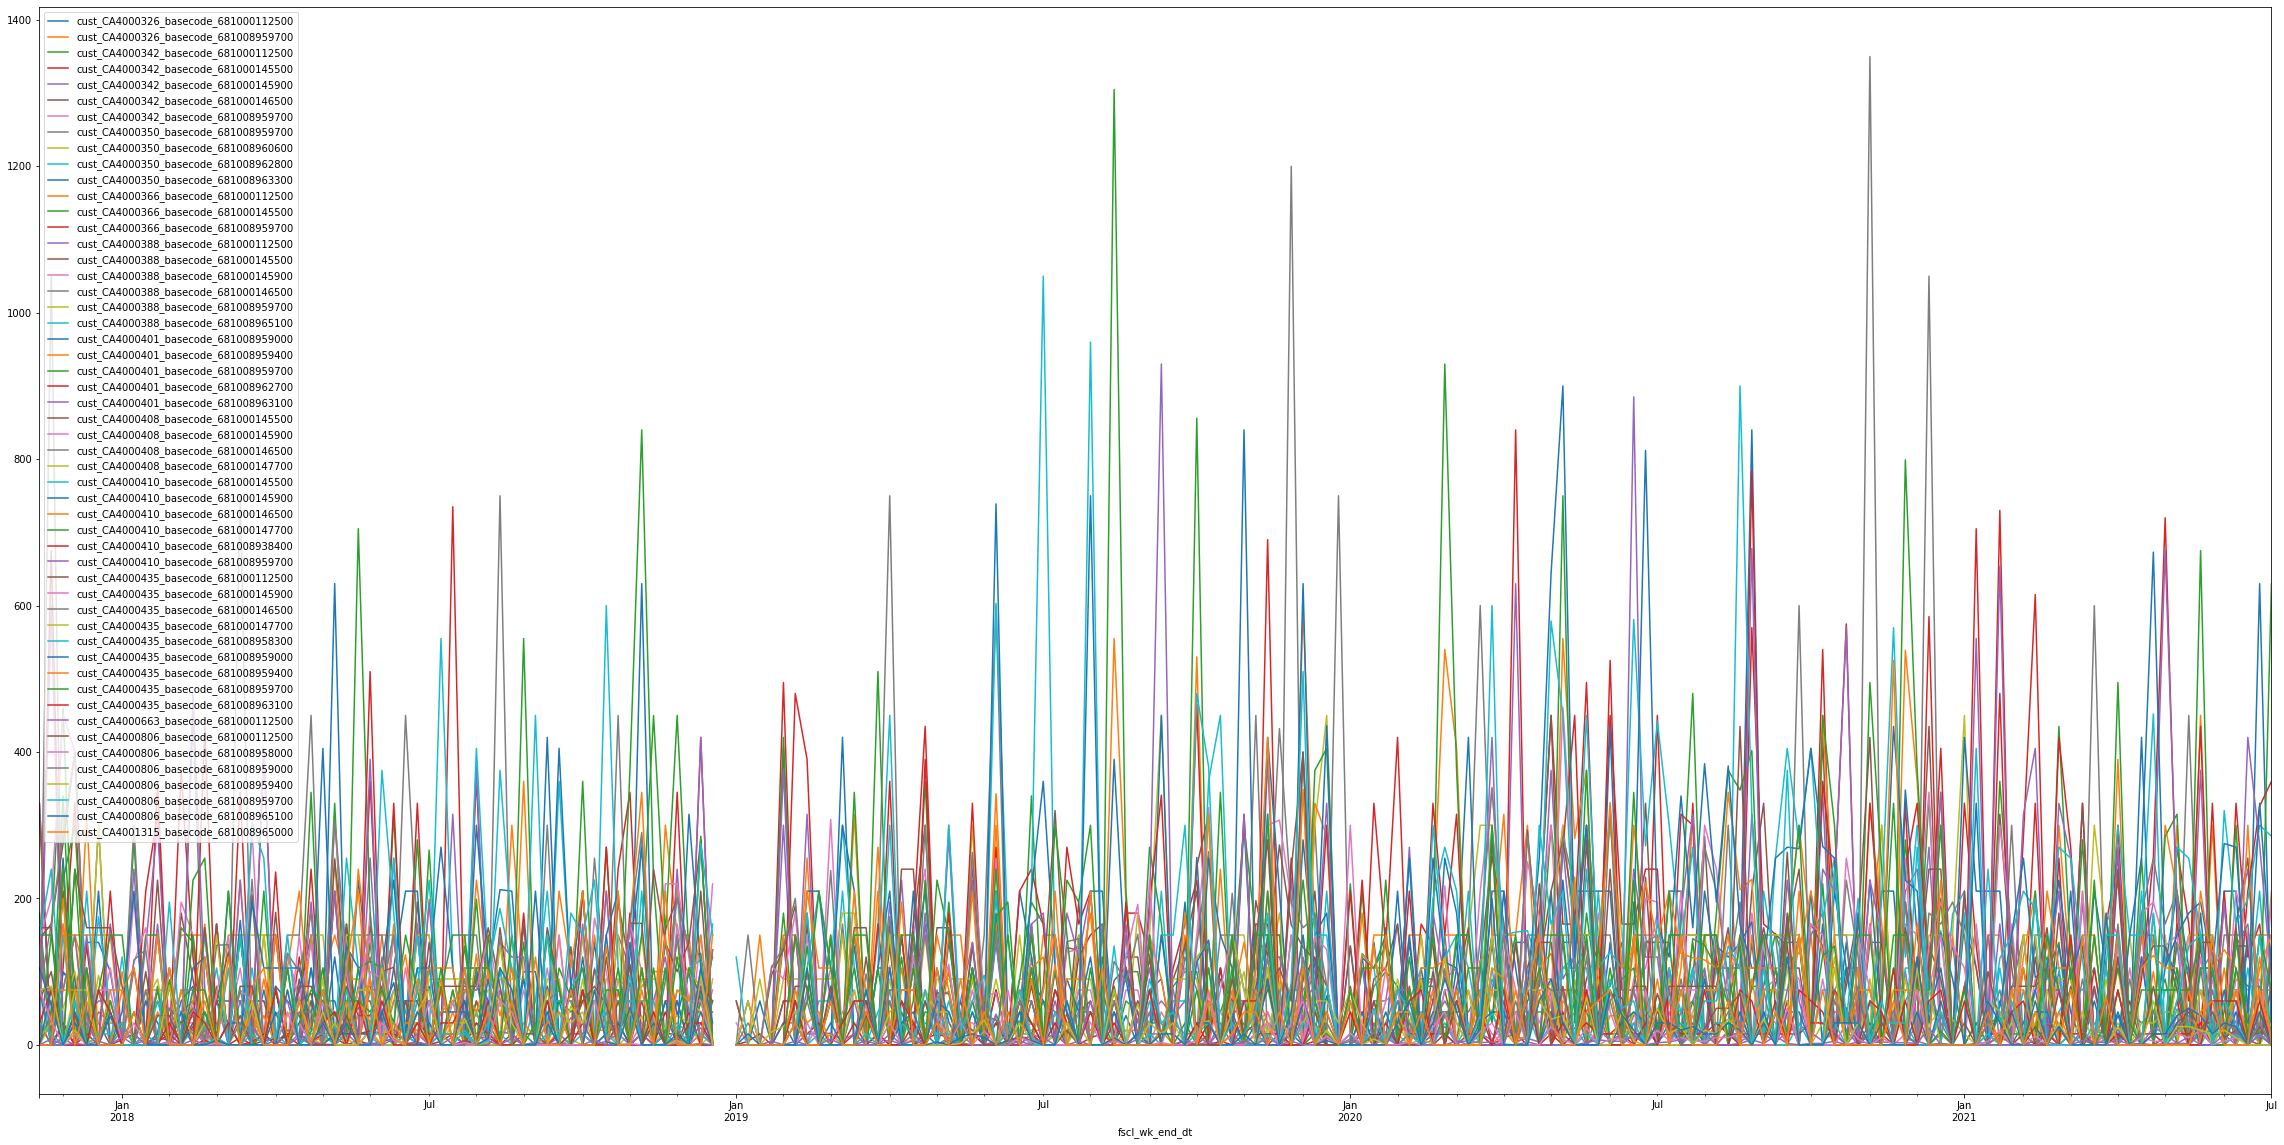

In [ ]:
df_bottom_level.plot(figsize = (40,20))

In [ ]:
df_po_vs_shipment_agg.groupby("uch_level_g")["basecode"].apply(set).to_frame()

,basecode
uch_level_g,
CA4000326,"{681008959700, 681000112500}"
CA4000342,"{681000146500, 681000145900, 681008959700, 681..."
CA4000350,"{681008960600, 681008962800, 681008959700, 681..."
CA4000366,"{681008959700, 681000112500, 681000145500}"
CA4000388,"{681000146500, 681000145900, 681008965100, 681..."
CA4000401,"{681008959400, 681008962700, 681008959700, 681..."
CA4000408,"{681000145900, 681000147700, 681000145500, 681..."
CA4000410,"{681008938400, 681000146500, 681000145900, 681..."
CA4000435,"{681000146500, 681008959400, 681000145900, 681..."


In [ ]:
df_middle_level_1 = df_po_vs_shipment_agg.reset_index().groupby(["fscl_wk_end_dt","uch_level_g"])[["dlv_units"]].agg(["sum"]).reset_index()
df_middle_level_1.columns = ['fscl_wk_end_dt','uch_level_g', 'dlv_units']
df_middle_level_1 = df_middle_level_1.pivot(index="fscl_wk_end_dt", columns="uch_level_g", values="dlv_units")
df_middle_level_1 = df_middle_level_1.fillna(0)
df_middle_level_1.columns = ['cust_' + c for c in df_middle_level_1]
df_middle_level_1.head()

,cust_CA4000326,cust_CA4000342,cust_CA4000350,cust_CA4000366,cust_CA4000388,cust_CA4000401,cust_CA4000408,cust_CA4000410,cust_CA4000435,cust_CA4000663,cust_CA4000806,cust_CA4001315
fscl_wk_end_dt,,,,,,,,,,,,
2017-11-18,75.000000000000000,1305.000000000000000,105.000000000000000,0.000000000000000,304.000000000000000,0.000000000000000,371.000000000000000,0.000000000000000,745.000000000000000,0.000000000000000,540.000000000000000,0.000000000000000
2017-11-25,75.000000000000000,0.000000000000000,1050.000000000000000,190.000000000000000,60.000000000000000,1350.000000000000000,560.000000000000000,0.000000000000000,700.000000000000000,8.000000000000000,586.000000000000000,0.000000000000000
2017-12-02,175.000000000000000,1030.000000000000000,0.000000000000000,685.000000000000000,50.000000000000000,473.000000000000000,1067.000000000000000,923.000000000000000,225.000000000000000,0.000000000000000,0.000000000000000,165.000000000000000
2017-12-09,225.000000000000000,555.000000000000000,0.000000000000000,30.000000000000000,131.000000000000000,540.000000000000000,1300.000000000000000,0.000000000000000,1005.000000000000000,2.000000000000000,195.000000000000000,0.000000000000000
2017-12-16,290.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,100.000000000000000,405.000000000000000,122.000000000000000,780.000000000000000,235.000000000000000,0.000000000000000,0.000000000000000,60.000000000000000


In [ ]:
df_middle_level_2 = df_po_vs_shipment_agg.reset_index().groupby(["fscl_wk_end_dt","basecode"])[["dlv_units"]].agg(["sum"]).reset_index()
df_middle_level_2.columns = ['fscl_wk_end_dt','basecode', 'dlv_units']
df_middle_level_2 = df_middle_level_2.pivot(index="fscl_wk_end_dt", columns="basecode", values="dlv_units")
df_middle_level_2 = df_middle_level_2.fillna(0)
df_middle_level_2.columns = ['basecode_' + str(c) for c in df_middle_level_2]
df_middle_level_2.head()

,basecode_681000112500,basecode_681000145500,basecode_681000145900,basecode_681000146500,basecode_681000147700,basecode_681008938400,basecode_681008958000,basecode_681008958300,basecode_681008959000,basecode_681008959400,basecode_681008959700,basecode_681008960600,basecode_681008962700,basecode_681008962800,basecode_681008963100,basecode_681008963300,basecode_681008965000,basecode_681008965100
fscl_wk_end_dt,,,,,,,,,,,,,,,,,,
2017-11-18,560.000000000000000,505.000000000000000,549.000000000000000,567.000000000000000,85.000000000000000,0.000000000000000,75.000000000000000,30.000000000000000,75.000000000000000,150.000000000000000,525.000000000000000,0.000000000000000,0.000000000000000,30.000000000000000,30.000000000000000,75.000000000000000,0.000000000000000,189.000000000000000
2017-11-25,308.000000000000000,315.000000000000000,335.000000000000000,165.000000000000000,105.000000000000000,0.000000000000000,33.000000000000000,15.000000000000000,153.000000000000000,185.000000000000000,1560.000000000000000,0.000000000000000,675.000000000000000,0.000000000000000,675.000000000000000,0.000000000000000,0.000000000000000,55.000000000000000
2017-12-02,640.000000000000000,1020.000000000000000,992.000000000000000,815.000000000000000,290.000000000000000,30.000000000000000,0.000000000000000,0.000000000000000,98.000000000000000,225.000000000000000,508.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,165.000000000000000,10.000000000000000
2017-12-09,377.000000000000000,760.000000000000000,610.000000000000000,670.000000000000000,175.000000000000000,0.000000000000000,15.000000000000000,30.000000000000000,165.000000000000000,245.000000000000000,850.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,86.000000000000000
2017-12-16,340.000000000000000,285.000000000000000,165.000000000000000,355.000000000000000,187.000000000000000,15.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,90.000000000000000,210.000000000000000,0.000000000000000,135.000000000000000,0.000000000000000,150.000000000000000,0.000000000000000,60.000000000000000,0.000000000000000


In [ ]:
df_top_level = df_po_vs_shipment_agg.reset_index().groupby(["fscl_wk_end_dt"])[["dlv_units"]].agg(["sum"]).reset_index()
df_top_level.columns = ['fscl_wk_end_dt','total']
#df_top_level = df_top.pivot(index="fscl_wk_end_dt", columns="uch_level_g", values="dlv_units")
df_top_level = df_top_level.fillna(0).set_index('fscl_wk_end_dt')
df_top_level.head()

,total
fscl_wk_end_dt,
2017-11-18,3445
2017-11-25,4579
2017-12-02,4793
2017-12-09,3983
2017-12-16,1992


In [ ]:
# join the DataFrames
hierarchy_df = df_bottom_level.join(df_middle_level_1).join(df_middle_level_2).join(df_top_level)
#hierarchy_df = df_bottom_level.join(df_middle_level_1).join(df_top_level)
hierarchy_df.index = pd.to_datetime(hierarchy_df.index)
#hierarchy_df = hierarchy_df.resample("QS").sum()

print(f"Number of time series at the bottom level: {df_bottom_level.shape[1]}")
print(f"Number of time series at the middle level_1: {df_middle_level_1.shape[1]}")
print(f"Number of time series at the middle level_2: {df_middle_level_2.shape[1]}")

hierarchy_df_orig = hierarchy_df.copy()
hierarchy_df = hierarchy_df[hierarchy_df.index <= '2020-12-26']

hierarchy_df.head()

Number of time series at the bottom level: 52
Number of time series at the middle level_1: 12
Number of time series at the middle level_2: 18


,cust_CA4000326_basecode_681000112500,cust_CA4000326_basecode_681008959700,cust_CA4000342_basecode_681000112500,cust_CA4000342_basecode_681000145500,cust_CA4000342_basecode_681000145900,cust_CA4000342_basecode_681000146500,cust_CA4000342_basecode_681008959700,cust_CA4000350_basecode_681008959700,cust_CA4000350_basecode_681008960600,cust_CA4000350_basecode_681008962800,cust_CA4000350_basecode_681008963300,cust_CA4000366_basecode_681000112500,cust_CA4000366_basecode_681000145500,cust_CA4000366_basecode_681008959700,cust_CA4000388_basecode_681000112500,cust_CA4000388_basecode_681000145500,cust_CA4000388_basecode_681000145900,cust_CA4000388_basecode_681000146500,cust_CA4000388_basecode_681008959700,cust_CA4000388_basecode_681008965100,cust_CA4000401_basecode_681008959000,cust_CA4000401_basecode_681008959400,cust_CA4000401_basecode_681008959700,cust_CA4000401_basecode_681008962700,cust_CA4000401_basecode_681008963100,cust_CA4000408_basecode_681000145500,cust_CA4000408_basecode_681000145900,cust_CA4000408_basecode_681000146500,cust_CA4000408_basecode_681000147700,cust_CA4000410_basecode_681000145500,cust_CA4000410_basecode_681000145900,cust_CA4000410_basecode_681000146500,cust_CA4000410_basecode_681000147700,cust_CA4000410_basecode_681008938400,cust_CA4000410_basecode_681008959700,cust_CA4000435_basecode_681000112500,cust_CA4000435_basecode_681000145900,cust_CA4000435_basecode_681000146500,cust_CA4000435_basecode_681000147700,cust_CA4000435_basecode_681008958300,...,cust_CA4000435_basecode_681008963100,cust_CA4000663_basecode_681000112500,cust_CA4000806_basecode_681000112500,cust_CA4000806_basecode_681008958000,cust_CA4000806_basecode_681008959000,cust_CA4000806_basecode_681008959400,cust_CA4000806_basecode_681008959700,cust_CA4000806_basecode_681008965100,cust_CA4001315_basecode_681008965000,cust_CA4000326,cust_CA4000342,cust_CA4000350,cust_CA4000366,cust_CA4000388,cust_CA4000401,cust_CA4000408,cust_CA4000410,cust_CA4000435,cust_CA4000663,cust_CA4000806,cust_CA4001315,basecode_681000112500,basecode_681000145500,basecode_681000145900,basecode_681000146500,basecode_681000147700,basecode_681008938400,basecode_681008958000,basecode_681008958300,basecode_681008959000,basecode_681008959400,basecode_681008959700,basecode_681008960600,basecode_681008962700,basecode_681008962800,basecode_681008963100,basecode_681008963300,basecode_681008965000,basecode_681008965100,total
fscl_wk_end_dt,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-11-18,0.000000000000000,75.000000000000000,180.000000000000000,330.000000000000000,330.000000000000000,315.000000000000000,150.000000000000000,0.000000000000000,0.000000000000000,30.000000000000000,75.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,160.000000000000000,30.000000000000000,0.000000000000000,30.000000000000000,0.000000000000000,84.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,145.000000000000000,144.000000000000000,72.000000000000000,10.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,160.000000000000000,75.000000000000000,150.000000000000000,75.000000000000000,30.000000000000000,...,30.000000000000000,0.000000000000000,60.000000000000000,75.000000000000000,75.000000000000000,75.000000000000000,150.000000000000000,105.000000000000000,0.000000000000000,75.000000000000000,1305.000000000000000,105.000000000000000,0.000000000000000,304.000000000000000,0.000000000000000,371.000000000000000,0.000000000000000,745.000000000000000,0.000000000000000,540.000000000000000,0.000000000000000,560.000000000000000,505.000000000000000,549.000000000000000,567.000000000000000,85.000000000000000,0.000000000000000,75.000000000000000,30.000000000000000,75.000000000000000,150.000000000000000,525.000000000000000,0.000000000000000,0.000000000000000,30.000000000000000,30.000000000000000,75.000000000000000,0.000000000000000,189.00000000

In [ ]:
uch_level_g = df_po_vs_shipment_agg["uch_level_g"].unique()
basecode = df_po_vs_shipment_agg["basecode"].unique()

total_cust = {'total_cust': ['cust_' + c for c in list(uch_level_g)]}
total_basecode = {'total_basecode': ['basecode_' + str(b) for b in list(basecode)]}

total_cust_basecode = {'cust_' + c: ['basecode_' + str(b[1]) for b in df_po_vs_shipment_agg.groupby(['uch_level_g','basecode','generic_cust_item_id'])[["dlv_units"]].agg(["sum"]).reset_index()[['uch_level_g','basecode','generic_cust_item_id']].to_numpy() if b[0]==c] for c in uch_level_g}
total_basecode_cust = {'basecode_' + str(b): ['cust_' + c[0] for c in df_po_vs_shipment_agg.groupby(['uch_level_g','basecode','generic_cust_item_id'])[["dlv_units"]].agg(["sum"]).reset_index()[['uch_level_g','basecode','generic_cust_item_id']].to_numpy() if c[1]==b] for b in basecode}

hierarchy = {**total_cust, **total_basecode, **total_cust_basecode, **total_basecode_cust}

hierarchy

{'basecode_681000112500': ['cust_CA4000326',
  'cust_CA4000342',
  'cust_CA4000366',
  'cust_CA4000388',
  'cust_CA4000435',
  'cust_CA4000663',
  'cust_CA4000806'],
 'basecode_681000145500': ['cust_CA4000342',
  'cust_CA4000366',
  'cust_CA4000388',
  'cust_CA4000408',
  'cust_CA4000410'],
 'basecode_681000145900': ['cust_CA4000342',
  'cust_CA4000388',
  'cust_CA4000408',
  'cust_CA4000410',
  'cust_CA4000435'],
 'basecode_681000146500': ['cust_CA4000342',
  'cust_CA4000388',
  'cust_CA4000408',
  'cust_CA4000410',
  'cust_CA4000435'],
 'basecode_681000147700': ['cust_CA4000408',
  'cust_CA4000410',
  'cust_CA4000435'],
 'basecode_681008938400': ['cust_CA4000410'],
 'basecode_681008958000': ['cust_CA4000806'],
 'basecode_681008958300': ['cust_CA4000435'],
 'basecode_681008959000': ['cust_CA4000401',
  'cust_CA4000435',
  'cust_CA4000806'],
 'basecode_681008959400': ['cust_CA4000401',
  'cust_CA4000435',
  'cust_CA4000806'],
 'basecode_681008959700': ['cust_CA4000326',
  'cust_CA40003

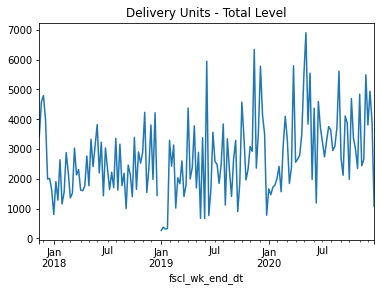

In [ ]:
hierarchy_df["total"].plot(title="Delivery Units - Total Level");

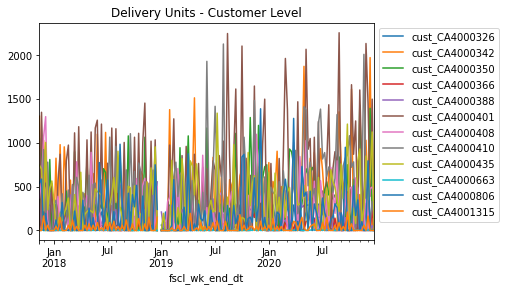

In [ ]:
ax = hierarchy_df[hierarchy['total_cust']].plot(title="Delivery Units - Customer Level")
ax.legend(bbox_to_anchor=(1.0, 1.0));

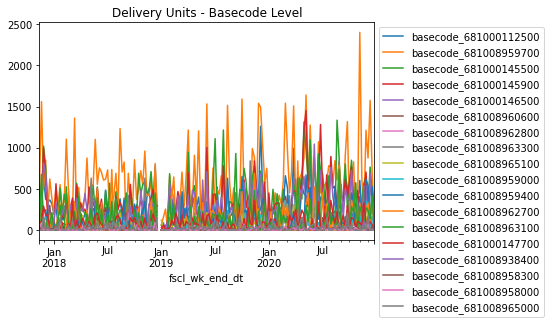

In [ ]:
ax = hierarchy_df[hierarchy['total_basecode']].plot(title="Delivery Units - Basecode Level")
ax.legend(bbox_to_anchor=(1.0, 1.0));

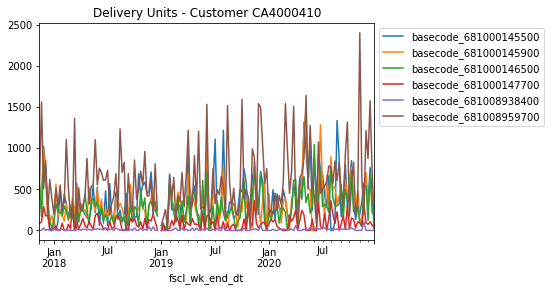

In [ ]:
ax = hierarchy_df[hierarchy['cust_CA4000410']].plot(title="Delivery Units - Customer CA4000410")
ax.legend(bbox_to_anchor=(1.0, 1.0));

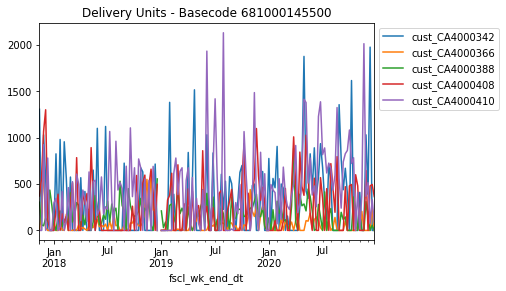

In [ ]:
ax = hierarchy_df[hierarchy['basecode_681000145500']].plot(title="Delivery Units - Basecode 681000145500")
ax.legend(bbox_to_anchor=(1.0, 1.0));

In [ ]:
hierarchy_df.head()

,cust_CA4000326_basecode_681000112500,cust_CA4000326_basecode_681008959700,cust_CA4000342_basecode_681000112500,cust_CA4000342_basecode_681000145500,cust_CA4000342_basecode_681000145900,cust_CA4000342_basecode_681000146500,cust_CA4000342_basecode_681008959700,cust_CA4000350_basecode_681008959700,cust_CA4000350_basecode_681008960600,cust_CA4000350_basecode_681008962800,cust_CA4000350_basecode_681008963300,cust_CA4000366_basecode_681000112500,cust_CA4000366_basecode_681000145500,cust_CA4000366_basecode_681008959700,cust_CA4000388_basecode_681000112500,cust_CA4000388_basecode_681000145500,cust_CA4000388_basecode_681000145900,cust_CA4000388_basecode_681000146500,cust_CA4000388_basecode_681008959700,cust_CA4000388_basecode_681008965100,cust_CA4000401_basecode_681008959000,cust_CA4000401_basecode_681008959400,cust_CA4000401_basecode_681008959700,cust_CA4000401_basecode_681008962700,cust_CA4000401_basecode_681008963100,cust_CA4000408_basecode_681000145500,cust_CA4000408_basecode_681000145900,cust_CA4000408_basecode_681000146500,cust_CA4000408_basecode_681000147700,cust_CA4000410_basecode_681000145500,cust_CA4000410_basecode_681000145900,cust_CA4000410_basecode_681000146500,cust_CA4000410_basecode_681000147700,cust_CA4000410_basecode_681008938400,cust_CA4000410_basecode_681008959700,cust_CA4000435_basecode_681000112500,cust_CA4000435_basecode_681000145900,cust_CA4000435_basecode_681000146500,cust_CA4000435_basecode_681000147700,cust_CA4000435_basecode_681008958300,...,cust_CA4000435_basecode_681008963100,cust_CA4000663_basecode_681000112500,cust_CA4000806_basecode_681000112500,cust_CA4000806_basecode_681008958000,cust_CA4000806_basecode_681008959000,cust_CA4000806_basecode_681008959400,cust_CA4000806_basecode_681008959700,cust_CA4000806_basecode_681008965100,cust_CA4001315_basecode_681008965000,cust_CA4000326,cust_CA4000342,cust_CA4000350,cust_CA4000366,cust_CA4000388,cust_CA4000401,cust_CA4000408,cust_CA4000410,cust_CA4000435,cust_CA4000663,cust_CA4000806,cust_CA4001315,basecode_681000112500,basecode_681000145500,basecode_681000145900,basecode_681000146500,basecode_681000147700,basecode_681008938400,basecode_681008958000,basecode_681008958300,basecode_681008959000,basecode_681008959400,basecode_681008959700,basecode_681008960600,basecode_681008962700,basecode_681008962800,basecode_681008963100,basecode_681008963300,basecode_681008965000,basecode_681008965100,total
fscl_wk_end_dt,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-11-18,0.000000000000000,75.000000000000000,180.000000000000000,330.000000000000000,330.000000000000000,315.000000000000000,150.000000000000000,0.000000000000000,0.000000000000000,30.000000000000000,75.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,160.000000000000000,30.000000000000000,0.000000000000000,30.000000000000000,0.000000000000000,84.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,145.000000000000000,144.000000000000000,72.000000000000000,10.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,160.000000000000000,75.000000000000000,150.000000000000000,75.000000000000000,30.000000000000000,...,30.000000000000000,0.000000000000000,60.000000000000000,75.000000000000000,75.000000000000000,75.000000000000000,150.000000000000000,105.000000000000000,0.000000000000000,75.000000000000000,1305.000000000000000,105.000000000000000,0.000000000000000,304.000000000000000,0.000000000000000,371.000000000000000,0.000000000000000,745.000000000000000,0.000000000000000,540.000000000000000,0.000000000000000,560.000000000000000,505.000000000000000,549.000000000000000,567.000000000000000,85.000000000000000,0.000000000000000,75.000000000000000,30.000000000000000,75.000000000000000,150.000000000000000,525.000000000000000,0.000000000000000,0.000000000000000,30.000000000000000,30.000000000000000,75.000000000000000,0.000000000000000,189.00000000

In [ ]:
hierarchy_df.columns

Index(['cust_CA4000326_basecode_681000112500',
       'cust_CA4000326_basecode_681008959700',
       'cust_CA4000342_basecode_681000112500',
       'cust_CA4000342_basecode_681000145500',
       'cust_CA4000342_basecode_681000145900',
       'cust_CA4000342_basecode_681000146500',
       'cust_CA4000342_basecode_681008959700',
       'cust_CA4000350_basecode_681008959700',
       'cust_CA4000350_basecode_681008960600',
       'cust_CA4000350_basecode_681008962800',
       'cust_CA4000350_basecode_681008963300',
       'cust_CA4000366_basecode_681000112500',
       'cust_CA4000366_basecode_681000145500',
       'cust_CA4000366_basecode_681008959700',
       'cust_CA4000388_basecode_681000112500',
       'cust_CA4000388_basecode_681000145500',
       'cust_CA4000388_basecode_681000145900',
       'cust_CA4000388_basecode_681000146500',
       'cust_CA4000388_basecode_681008959700',
       'cust_CA4000388_basecode_681008965100',
       'cust_CA4000401_basecode_681008959000',
       'cust_

In [ ]:
df_cust_basecode = pd.DataFrame()
for k in total_cust_basecode.keys():
    basecode_list = total_cust_basecode[k]
    for b in basecode_list:
        list_of_row_tuple = [(k,b)]
        temp_df = pd.DataFrame(data=list_of_row_tuple, columns = ['cust', 'basecode'])
        df_cust_basecode = df_cust_basecode.append(temp_df)

df_cust_basecode = df_cust_basecode.reset_index()
df_cust_basecode =  df_cust_basecode[['cust', 'basecode']]
df_cust_basecode

,cust,basecode
0,cust_CA4000326,basecode_681000112500
1,cust_CA4000326,basecode_681008959700
2,cust_CA4000342,basecode_681000112500
3,cust_CA4000342,basecode_681000145500
4,cust_CA4000342,basecode_681000145900
5,cust_CA4000342,basecode_681000146500
6,cust_CA4000342,basecode_681008959700
7,cust_CA4000350,basecode_681008959700
8,cust_CA4000350,basecode_681008960600
9,cust_CA4000350,basecode_681008962800


In [ ]:
df_basecode_cust = pd.DataFrame()
for k in total_basecode_cust.keys():
    cust_list = total_basecode_cust[k]
    #print(cust_list)
    for c in cust_list:
        temp_df = pd.DataFrame(data=[(k, c)])
        df_basecode_cust = df_basecode_cust.append(temp_df)

df_basecode_cust.reset_index(inplace=True)
df_basecode_cust.drop(columns=['index'], inplace=True)
df_basecode_cust.columns = ['basecode','cust']
df_basecode_cust

,basecode,cust
0,basecode_681000112500,cust_CA4000326
1,basecode_681000112500,cust_CA4000342
2,basecode_681000112500,cust_CA4000366
3,basecode_681000112500,cust_CA4000388
4,basecode_681000112500,cust_CA4000435
5,basecode_681000112500,cust_CA4000663
6,basecode_681000112500,cust_CA4000806
7,basecode_681008959700,cust_CA4000326
8,basecode_681008959700,cust_CA4000342
9,basecode_681008959700,cust_CA4000350


In [ ]:
# Level 1


In [ ]:

daily_df=hierarchy_df.iloc[:,0:52]

diff3=daily_df.diff()
diff3


,cust_CA4000326_basecode_681000112500,cust_CA4000326_basecode_681008959700,cust_CA4000342_basecode_681000112500,cust_CA4000342_basecode_681000145500,cust_CA4000342_basecode_681000145900,cust_CA4000342_basecode_681000146500,cust_CA4000342_basecode_681008959700,cust_CA4000350_basecode_681008959700,cust_CA4000350_basecode_681008960600,cust_CA4000350_basecode_681008962800,cust_CA4000350_basecode_681008963300,cust_CA4000366_basecode_681000112500,cust_CA4000366_basecode_681000145500,cust_CA4000366_basecode_681008959700,cust_CA4000388_basecode_681000112500,cust_CA4000388_basecode_681000145500,cust_CA4000388_basecode_681000145900,cust_CA4000388_basecode_681000146500,cust_CA4000388_basecode_681008959700,cust_CA4000388_basecode_681008965100,cust_CA4000401_basecode_681008959000,cust_CA4000401_basecode_681008959400,cust_CA4000401_basecode_681008959700,cust_CA4000401_basecode_681008962700,cust_CA4000401_basecode_681008963100,cust_CA4000408_basecode_681000145500,cust_CA4000408_basecode_681000145900,cust_CA4000408_basecode_681000146500,cust_CA4000408_basecode_681000147700,cust_CA4000410_basecode_681000145500,cust_CA4000410_basecode_681000145900,cust_CA4000410_basecode_681000146500,cust_CA4000410_basecode_681000147700,cust_CA4000410_basecode_681008938400,cust_CA4000410_basecode_681008959700,cust_CA4000435_basecode_681000112500,cust_CA4000435_basecode_681000145900,cust_CA4000435_basecode_681000146500,cust_CA4000435_basecode_681000147700,cust_CA4000435_basecode_681008958300,cust_CA4000435_basecode_681008959000,cust_CA4000435_basecode_681008959400,cust_CA4000435_basecode_681008959700,cust_CA4000435_basecode_681008963100,cust_CA4000663_basecode_681000112500,cust_CA4000806_basecode_681000112500,cust_CA4000806_basecode_681008958000,cust_CA4000806_basecode_681008959000,cust_CA4000806_basecode_681008959400,cust_CA4000806_basecode_681008959700,cust_CA4000806_basecode_681008965100,cust_CA4001315_basecode_681008965000
fscl_wk_end_dt,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-11-18,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2017-11-25,0.000000000000000,0.000000000000000,-180.000000000000000,-330.000000000000000,-330.000000000000000,-315.000000000000000,-150.000000000000000,1050.000000000000000,0.000000000000000,-30.000000000000000,-75.000000000000000,40.000000000000000,150.000000000000000,0.000000000000000,-160.000000000000000,-30.000000000000000,60.000000000000000,-30.000000000000000,0.000000000000000,-84.000000000000000,0.000000000000000,30.000000000000000,45.000000000000000,675.000000000000000,600.000000000000000,20.000000000000000,56.000000000000000,93.000000000000000,20.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,-150.000000000000000,0.000000000000000,-15.000000000000000,75.000000000000000,0.000000000000000,0.000000000000000,45.000000000000000,8.000000000000000,40.000000000000000,-42.000000000000000,3.000000000000000,5.000000000000000,90.000000000000000,-50.000000000000000,0.000000000000000
2017-12-02,100.000000000000000,0.000000000000000,340.000000000000000,105.000000000000000,210.000000000000000,210.000000000000000,165.000000000000000,-1050.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,160.000000000000000,310.000000000000000,25.000000000000000,0.000000000000000,30.000000000000000,-60.000000000000000,0.000000000000000,10.000000000000000,10.000000000000000,98.000000000000000,120.000000000000000,180.000000000000000,-675.000000000000000,-600.000000000000000,110.000000000000000,252.000000000000000,125.000000000000000,20.000000000000000,150.000000000000000,255.000000000000000,240.000000000000000,240.000000000000000,30.000000000000000,8.000000000000000,-160.000000000000000,0.000000000000000,75.000000000000000,-75.000000000000000,-15.00000000

In [ ]:
diff3.columns

Index(['cust_CA4000326_basecode_681000112500',
       'cust_CA4000326_basecode_681008959700',
       'cust_CA4000342_basecode_681000112500',
       'cust_CA4000342_basecode_681000145500',
       'cust_CA4000342_basecode_681000145900',
       'cust_CA4000342_basecode_681000146500',
       'cust_CA4000342_basecode_681008959700',
       'cust_CA4000350_basecode_681008959700',
       'cust_CA4000350_basecode_681008960600',
       'cust_CA4000350_basecode_681008962800',
       'cust_CA4000350_basecode_681008963300',
       'cust_CA4000366_basecode_681000112500',
       'cust_CA4000366_basecode_681000145500',
       'cust_CA4000366_basecode_681008959700',
       'cust_CA4000388_basecode_681000112500',
       'cust_CA4000388_basecode_681000145500',
       'cust_CA4000388_basecode_681000145900',
       'cust_CA4000388_basecode_681000146500',
       'cust_CA4000388_basecode_681008959700',
       'cust_CA4000388_basecode_681008965100',
       'cust_CA4000401_basecode_681008959000',
       'cust_

In [ ]:
train_df,test_df = diff3[0:12], diff3[12:]  
train_df.shape,test_df.shape

((12, 52), (151, 52))

In [ ]:
train_df

,cust_CA4000326_basecode_681000112500,cust_CA4000326_basecode_681008959700,cust_CA4000342_basecode_681000112500,cust_CA4000342_basecode_681000145500,cust_CA4000342_basecode_681000145900,cust_CA4000342_basecode_681000146500,cust_CA4000342_basecode_681008959700,cust_CA4000350_basecode_681008959700,cust_CA4000350_basecode_681008960600,cust_CA4000350_basecode_681008962800,cust_CA4000350_basecode_681008963300,cust_CA4000366_basecode_681000112500,cust_CA4000366_basecode_681000145500,cust_CA4000366_basecode_681008959700,cust_CA4000388_basecode_681000112500,cust_CA4000388_basecode_681000145500,cust_CA4000388_basecode_681000145900,cust_CA4000388_basecode_681000146500,cust_CA4000388_basecode_681008959700,cust_CA4000388_basecode_681008965100,cust_CA4000401_basecode_681008959000,cust_CA4000401_basecode_681008959400,cust_CA4000401_basecode_681008959700,cust_CA4000401_basecode_681008962700,cust_CA4000401_basecode_681008963100,cust_CA4000408_basecode_681000145500,cust_CA4000408_basecode_681000145900,cust_CA4000408_basecode_681000146500,cust_CA4000408_basecode_681000147700,cust_CA4000410_basecode_681000145500,cust_CA4000410_basecode_681000145900,cust_CA4000410_basecode_681000146500,cust_CA4000410_basecode_681000147700,cust_CA4000410_basecode_681008938400,cust_CA4000410_basecode_681008959700,cust_CA4000435_basecode_681000112500,cust_CA4000435_basecode_681000145900,cust_CA4000435_basecode_681000146500,cust_CA4000435_basecode_681000147700,cust_CA4000435_basecode_681008958300,cust_CA4000435_basecode_681008959000,cust_CA4000435_basecode_681008959400,cust_CA4000435_basecode_681008959700,cust_CA4000435_basecode_681008963100,cust_CA4000663_basecode_681000112500,cust_CA4000806_basecode_681000112500,cust_CA4000806_basecode_681008958000,cust_CA4000806_basecode_681008959000,cust_CA4000806_basecode_681008959400,cust_CA4000806_basecode_681008959700,cust_CA4000806_basecode_681008965100,cust_CA4001315_basecode_681008965000
fscl_wk_end_dt,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-11-18,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2017-11-25,0.000000000000000,0.000000000000000,-180.000000000000000,-330.000000000000000,-330.000000000000000,-315.000000000000000,-150.000000000000000,1050.000000000000000,0.000000000000000,-30.000000000000000,-75.000000000000000,40.000000000000000,150.000000000000000,0.000000000000000,-160.000000000000000,-30.000000000000000,60.000000000000000,-30.000000000000000,0.000000000000000,-84.000000000000000,0.000000000000000,30.000000000000000,45.000000000000000,675.000000000000000,600.000000000000000,20.000000000000000,56.000000000000000,93.000000000000000,20.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,-150.000000000000000,0.000000000000000,-15.000000000000000,75.000000000000000,0.000000000000000,0.000000000000000,45.000000000000000,8.000000000000000,40.000000000000000,-42.000000000000000,3.000000000000000,5.000000000000000,90.000000000000000,-50.000000000000000,0.000000000000000
2017-12-02,100.000000000000000,0.000000000000000,340.000000000000000,105.000000000000000,210.000000000000000,210.000000000000000,165.000000000000000,-1050.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,160.000000000000000,310.000000000000000,25.000000000000000,0.000000000000000,30.000000000000000,-60.000000000000000,0.000000000000000,10.000000000000000,10.000000000000000,98.000000000000000,120.000000000000000,180.000000000000000,-675.000000000000000,-600.000000000000000,110.000000000000000,252.000000000000000,125.000000000000000,20.000000000000000,150.000000000000000,255.000000000000000,240.000000000000000,240.000000000000000,30.000000000000000,8.000000000000000,-160.000000000000000,0.000000000000000,75.000000000000000,-75.000000000000000,-15.00000000

In [ ]:
test_df

,cust_CA4000326_basecode_681000112500,cust_CA4000326_basecode_681008959700,cust_CA4000342_basecode_681000112500,cust_CA4000342_basecode_681000145500,cust_CA4000342_basecode_681000145900,cust_CA4000342_basecode_681000146500,cust_CA4000342_basecode_681008959700,cust_CA4000350_basecode_681008959700,cust_CA4000350_basecode_681008960600,cust_CA4000350_basecode_681008962800,cust_CA4000350_basecode_681008963300,cust_CA4000366_basecode_681000112500,cust_CA4000366_basecode_681000145500,cust_CA4000366_basecode_681008959700,cust_CA4000388_basecode_681000112500,cust_CA4000388_basecode_681000145500,cust_CA4000388_basecode_681000145900,cust_CA4000388_basecode_681000146500,cust_CA4000388_basecode_681008959700,cust_CA4000388_basecode_681008965100,cust_CA4000401_basecode_681008959000,cust_CA4000401_basecode_681008959400,cust_CA4000401_basecode_681008959700,cust_CA4000401_basecode_681008962700,cust_CA4000401_basecode_681008963100,cust_CA4000408_basecode_681000145500,cust_CA4000408_basecode_681000145900,cust_CA4000408_basecode_681000146500,cust_CA4000408_basecode_681000147700,cust_CA4000410_basecode_681000145500,cust_CA4000410_basecode_681000145900,cust_CA4000410_basecode_681000146500,cust_CA4000410_basecode_681000147700,cust_CA4000410_basecode_681008938400,cust_CA4000410_basecode_681008959700,cust_CA4000435_basecode_681000112500,cust_CA4000435_basecode_681000145900,cust_CA4000435_basecode_681000146500,cust_CA4000435_basecode_681000147700,cust_CA4000435_basecode_681008958300,cust_CA4000435_basecode_681008959000,cust_CA4000435_basecode_681008959400,cust_CA4000435_basecode_681008959700,cust_CA4000435_basecode_681008963100,cust_CA4000663_basecode_681000112500,cust_CA4000806_basecode_681000112500,cust_CA4000806_basecode_681008958000,cust_CA4000806_basecode_681008959000,cust_CA4000806_basecode_681008959400,cust_CA4000806_basecode_681008959700,cust_CA4000806_basecode_681008965100,cust_CA4001315_basecode_681008965000
fscl_wk_end_dt,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-02-10,60.000000000000000,75.000000000000000,160.000000000000000,375.000000000000000,45.000000000000000,180.000000000000000,195.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,-6.000000000000000,20.000000000000000,15.000000000000000,30.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,-20.000000000000000,-38.000000000000000,-40.000000000000000,0.000000000000000,-105.000000000000000,-105.000000000000000,-105.000000000000000,-89.000000000000000,-15.000000000000000,0.000000000000000,-80.000000000000000,0.000000000000000,75.000000000000000,0.000000000000000,0.000000000000000,45.000000000000000,75.000000000000000,0.000000000000000,-30.000000000000000,-5.000000000000000,-40.000000000000000,-3.000000000000000,0.000000000000000,-81.000000000000000,-195.000000000000000,0.000000000000000,0.000000000000000
2018-02-17,20.000000000000000,0.000000000000000,-20.000000000000000,-255.000000000000000,15.000000000000000,-90.000000000000000,-45.000000000000000,450.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,150.000000000000000,25.000000000000000,20.000000000000000,-30.000000000000000,0.000000000000000,-15.000000000000000,30.000000000000000,21.000000000000000,30.000000000000000,60.000000000000000,225.000000000000000,0.000000000000000,480.000000000000000,20.000000000000000,10.000000000000000,40.000000000000000,0.000000000000000,0.000000000000000,105.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,75.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,-45.000000000000000,-75.000000000000000,75.000000000000000,45.000000000000000,7.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000
2018-02-24,-80.00000000